In [382]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [383]:
import os
import shutil
import time

# Plot Space average of u(t)

In [384]:
dt = 0.1
tspan = 19
tspan/dt

190.0

In [385]:
dx = 0.1
L = 64
R0 = 25

In [386]:
T = 25
C0 = 1
A = 1

In [387]:
title = "Circular island R0 = "+str(R0) + "\n"
#title = title + "C = " + str(C0) + "\n"
title = title + "$C = "+ str(C0) + " + "+str(A)+"*sin(2\pi t/"+str(T)+")$\n"
title = title + "dt = " + str(dt) + " dx = " + str(dx) + " L = " + str(L) + "\n"

# Motion by curvature
As the border is circular, here we check motion by curvature ($v=-\kappa$) by checking the relation
$$R^2 = 2(t_{coll} - t)$$
where $t_{coll}$ is the time when the island collapses to $R=0$.

It is simpler to check this relation instead of calculating $dv/dt$ and $1/\kappa$.

# Plot final state $|\nabla u|^2$

/tmp/ipykernel_4623/1633877741.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))


Text(0.5, 1.0, '$(\\partial_x u)^2 + (\\partial_y u)^2$\nt = 300.000000')

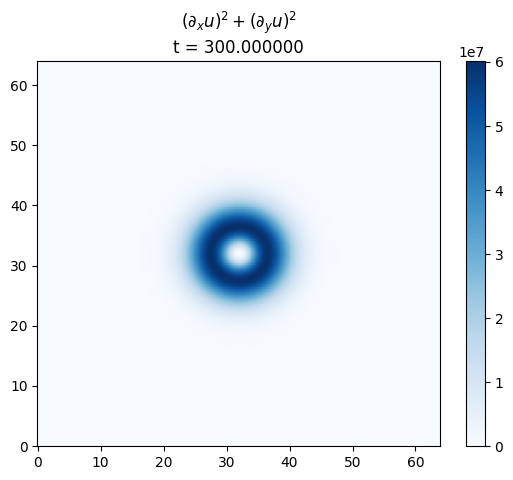

In [388]:
f = open("../state_gradient.dat", "r")
N = int(L/dx)
x = np.zeros(N)
y = np.zeros(N)
Z = np.zeros((N,N))
i = 0
for row in f:
    if i != 0:
        a, b, c = row.split(" ")
        #a, b = row.split("	")
        J = np.mod(i-1,N)
        I = int((i-1)/N)
        x[I] = float(a)
        y[J] = float(b)
        Z[I][J] = float(c)
    else:
        N, tmax, dx = row.split(" ")
        dx = float(dx)
        N = int(N)

    i = i + 1

#x = x[0:i-1]
#y = y[0:i-1]

# Make up some fake data
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize = (6.5,5))
fig.subplots_adjust(wspace=0.3)

# Blues
#plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.get_cmap('Blues'))
plt.colorbar()
#plt.axis([-3, 3, -3, 3])
plt.title('$(\partial_x u)^2 + (\partial_y u)^2$\nt = ' + str(tmax))
#plt.title("t = " + str(tmax))

1.5756417377861212


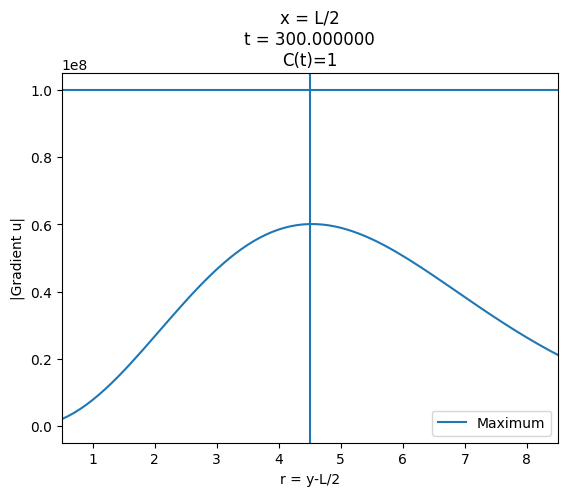

In [389]:
# Plot a slice
import scipy.stats


plt.plot(y-L/2, Z[int(len(y)/2)])
plt.title("x = L/2\nt = " + str(tmax) + "\nC(t)=1")
plt.xlabel("r = y-L/2")
plt.ylabel("|Gradient u|")


temp = Z[int(len(y)/2)][int(len(y)/2):len(y)]
index = np.argmax(temp) + int(len(y)/2)
Rlast = y[index]-L/2
eps = 4
plt.xlim(Rlast-eps,Rlast+eps)
plt.axvline(Rlast, label="Maximum")
plt.axhline(1e8)
plt.legend()

print(scipy.stats.skew(Z[int(len(y)/2)]))

### Measure $R^2$ by integrating $|\nabla u|^2$

In [390]:
experiments_list = ["C=0.1 R0=25 dx=0.1 dt=0.3", "C=0.1 R0=25 dx=0.1"]

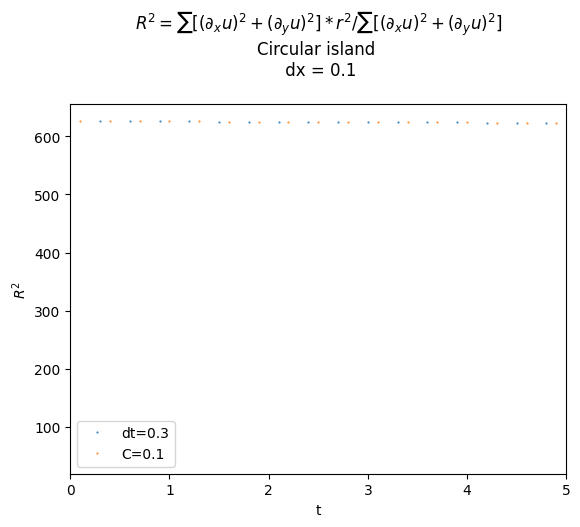

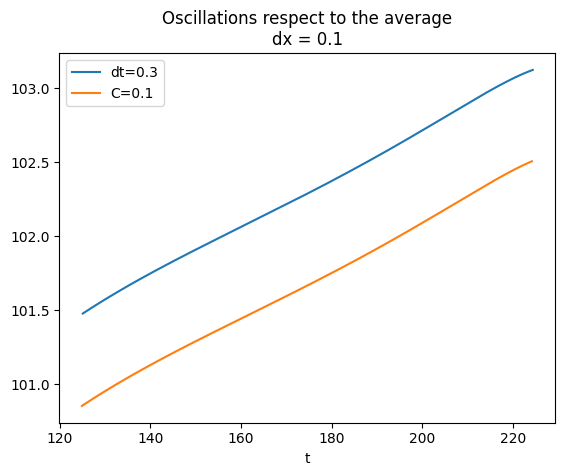

In [394]:
fig, ax = plt.subplots()                    # Main canvas
fig_oscill, ax_oscill = plt.subplots()      # Canvas for oscillations relative to the average
Amplitudes = np.zeros(len(experiments_list))    # Oscillations amplitudes
Slopes = np.zeros(len(experiments_list))        # Slope of the average line
index = 0
for experiment_folder in experiments_list:
    for folder in sorted(os.listdir("../.saves/" + experiment_folder), reverse=True):
        # Read data
        f = open("../.saves/" + experiment_folder + "/" + folder + "/fileRadiout.dat", "r")
        N = 10000
        tt = np.zeros(N)
        R2 = np.zeros(N)

        i = 0
        for row in f:
            a, b = row.split(" ")
            tt[i] = float(a)
            R2[i] = float(b)
            i = i + 1
        f.close()
        tt = tt[0:i]
        R2 = R2[0:i]
        # Read custom label
        f = open("../.saves/" + experiment_folder + "/" + folder + "/label.dat", "r")
        labell = experiment_folder
        for row in f:
            labell = row
        if row == "":
            labell = experiment_folder

        # Plot
        p = ax.plot(tt, R2,'.', label=labell, ms=1)
        # Calculate the average over a period
        n2T = int(2*T/(tt[1]-tt[0]))  # Number of steps corresponding to 2 Periods
        nT = int(n2T/2)
        nThalf = int(nT/2)
        R2ave = np.zeros(len(R2)-n2T)
        ttsave = np.arange(0,len(tt)-n2T)
        for i in np.arange(0, len(R2)):
            if i >= n2T:
                R2ave[i-n2T] = np.average(R2[i-n2T:i])
                ttsave[i-n2T] = tt[i]-T
        #ax.plot(ttsave, R2ave, "--", label="Average over [t+-T]", color = p[0].get_color())
        ### Slope of the average
        #Slopes[index] = np.mean(R2ave[int(0.25*len(R2ave)):int(0.75*len(R2ave))]-R2ave[int(0.25*len(R2ave))-1:int(0.75*len(R2ave))-1])
        Slopes[index] = (R2ave[int(0.75*len(R2ave))]-R2ave[int(0.5*len(R2ave))])/(0.25*len(R2ave)*(tt[1]-tt[0]))
        # Calculate the amplitude of the oscillations
        tmin_ampl = 100
        imin_ampl = int(tmin_ampl/(tt[1]-tt[0]))
        imax_ampl = imin_ampl + 2*n2T
        tempR2 = R2[imin_ampl:imax_ampl]-R2ave[imin_ampl+nT:imax_ampl+nT]
        ax_oscill.plot(tt[imin_ampl+nT:imax_ampl+nT], tempR2, label = labell)
        ### Quantify the amplitude as the last peak minus the first antipeak
        Amplitudes[index] = (np.max(tempR2)-np.min(tempR2))/2

        index = index + 1


# Motion by curvature
R2_expected = R2[0]*np.ones(len(tt))-2*tt
ax.plot(tt, R2_expected,'--',label="Motion by curvature", color="black")

ax.set_xlabel("t")
ax_oscill.set_xlabel("t")
ax.set_ylabel("$R^2$")    # Plot R^2-R0^2 in order to have a quantity independent on R0 (expected value = -2t)
ax.grid()

# Title
title = ""
title = title + "$R^2 = \sum[(\partial_x u)^2 + (\partial_y u)^2]*r^2 / \sum [(\partial_x u)^2 + (\partial_y u)^2]$"
title = title + "\nCircular island " 
#title = title + "R0 = "+str(R0)+"\n"
#title = title + "$C = "+ str(C0) + " + "+str(A)+"*sin(2\pi t/"+str(T)+")$\n"
title = title + "\n"
#title = title + "dt = " + str(dt) + "\n"
title = title + " dx = " + str(dx) + "\n"
#title = title + " L = " + str(L)

title_oscill = "Oscillations respect to the average\n"
title_oscill = title_oscill + "dx = 0.1"

ax.set_xlim(0,250)

ax.grid()
ax.set_title(title)
ax_oscill.set_title(title_oscill)
ax.legend()
ax_oscill.legend()

In [392]:
dts = np.array([0.1, 0.3])

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

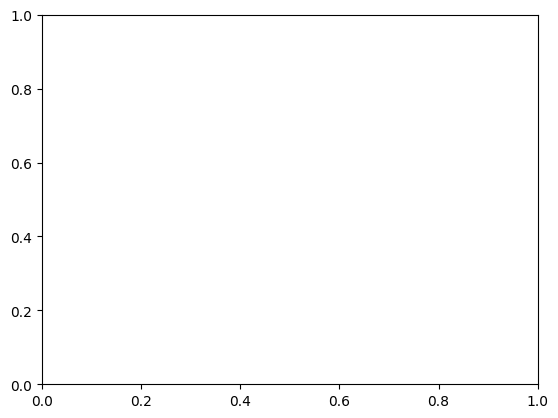

In [393]:
plt.plot(dt, Amplitudes,'*')
plt.title("Amplitude of oscillations\n Half of peak to peak distance\ndx=0.1")
plt.xlabel("dt")
print(Amplitudes)

[-2.05689001 -2.04432395]


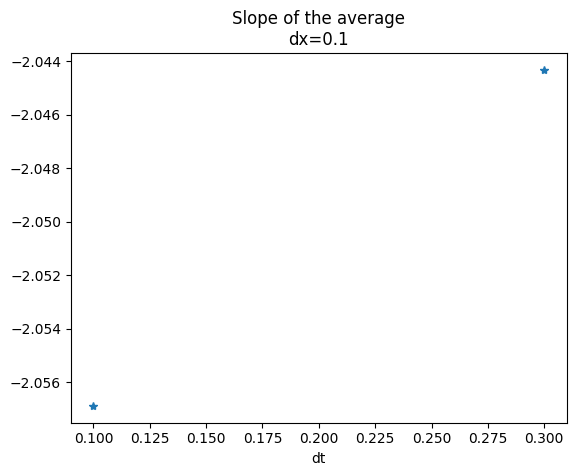

In [ ]:
plt.plot(dts, Slopes,"*")
plt.title("Slope of the average\ndx=0.1")
plt.xlabel("dt")
print(Slopes)